# M3: WEEK 2 - Bag of Visual Words Image Classification
### Team 8: Igor Ugarte, Juan A. Rodríguez, David Serrano and Francesc Net


Our work is structured as follows: In Section 1 we introduce the Bag of Words methodology for multiclass classification. We describe the methods that we use for the experiments in feature engineering and classifier options. In Section 2 we perfom many experiments to find the best set of parameters in this weeks proposal. In Section 3 we include some helper functions to plot results.

## Table of Contents:
* [1. Introduction: Basic Bag of Words method](#baseline)
* [2. Improvements to the code and experiments](#experiments)
    * [Experiment 1](#exp1)
    * [Experiment 2](#exp2)
    * [Experiment 3](#exp3)
    * [Experiment 4](#exp4)
    * [Experiment 5](#exp5)
    * [Experiment 6](#exp6)
    * [Our best method](#best)
* [3. Annex](#annex)


## 1. Introduction: Basic Bag of Words method <a class="anchor" id="baseline"></a>

The general idea of Bag of Visual Words is to represent an image as a set of features. Features consist of local descriptors found on keypoints. To do that, 3 main steps have to be followed:

1. <b>Local Feature Extraction</b>: The first step is to detect features and extract descriptors from each image in the dataset. For this work we will only use Dense SIFT descriptors, and will perform experiments with some further layers of feature engineering like normalization, standardization, and spatial pyramids.


2. <b>Global Image Representation</b>: This stage builds a visual word dictionary clustering the local descriptors found throughout the dataset. The center of each cluster will be used as a visual word, and a codebook is generated. The next step is to extract descriptors from the images and match them to visual words in the codebook, to generate a histogram of visual words (or a bag of words) for a given image. 


3. <b>Classification</b>: Finally, we train and fit a classifier using the global features and the training labels.  In this week's deliberable we experiment with SVM and XGBoost classifiers. We also test using Fisher Vectors representation with SVM.

We first prepare the environment for the experiments

In [27]:
# General imports
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve
from sklearn.preprocessing import normalize
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from itertools import cycle
import pickle
import os.path

Read the train and test files

In [41]:
train_images_filenames = pickle.load(open('train_images_filenames.dat','rb'))
test_images_filenames = pickle.load(open('test_images_filenames.dat','rb'))
train_images_filenames = ['..' + n[15:] for n in train_images_filenames]
test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]
train_labels = pickle.load(open('train_labels.dat','rb'))
test_labels = pickle.load(open('test_labels.dat','rb'))

print(f'{len(train_images_filenames)} training images')
print(f'{len(test_images_filenames)} test images')

1881 training images
807 test images


## 2. Improvements of the method and experiments <a class="anchor" id="experiments"></a>
The following is a set of experiments to improve the baseline method. Dense SIFT will be used, as it was the method that provided us better results from the past week.

###  2.1. Experiment 1: Dense Sift with varying Scales and steps <a class="anchor" id="exp1"></a>

In this first experiment we will try some values for the keypoints in the Dense SIFT: The idea is to change the keypoint sizes and to add some space between the keypoints. This will be done with the variables step_size (it will represent the size of the keypoint) and multiplicator (it will represent if there are space between the keypoints).

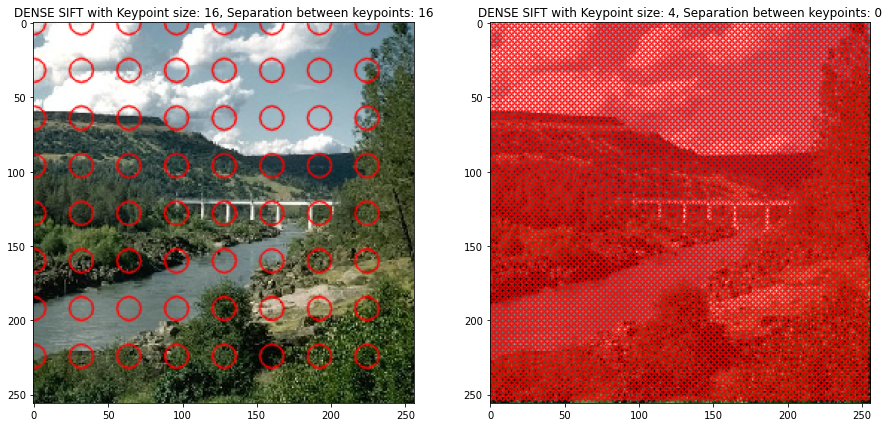

In [86]:
ima = cv2.imread(train_images_filenames[0])
gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)

SIFT_detector = cv2.SIFT_create()           # Descriptors initialization

step_size = 16
multiplicator = 2
kpDENSE = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size*multiplicator) for x in range(0, gray.shape[1], step_size*multiplicator)]
RGB_ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
imgDENSE = cv2.drawKeypoints(RGB_ima, kpDENSE,  0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.rcParams['figure.figsize'] = [15, 15]
plt.subplot(121)
plt.title(f'DENSE SIFT with Keypoint size: {step_size}, Separation between keypoints: {step_size*(multiplicator-1)}')
plt.imshow(imgDENSE)

step_size = 4
multiplicator = 1
kpDENSE = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size*multiplicator) for x in range(0, gray.shape[1], step_size*multiplicator)]
RGB_ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
imgDENSE = cv2.drawKeypoints(RGB_ima, kpDENSE,  0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(122)
plt.title(f'DENSE SIFT with Keypoint size: {step_size}, Separation between keypoints: {step_size*(multiplicator-1)}')
plt.imshow(imgDENSE)

plt.show()


Here we can see some examples before introducing our code: In the first image we see that the keypoints have a bigger size and they have a separation, and in the second image we have keypoints with a smaller size and without any kind of separation.The idea in the next piece of code is to play with this two parameters and to obtain the results of the best combination. We made a first attempt by varying the SIFT radius in the orders of 10, 100 and 1000 and found out that best results where given from 10 to 40.

In [26]:
step_size = [ 20, 24, 28]                   # Parameter to adjust the size of the keypoints
multiplicator = [1, 2]                      # If multiplicator > 1, there will be space between keypoints. 
k = 800                                     # Number of visual words (for the KMEANS)
best_acc = 0    
SIFT_detector = cv2.SIFT_create()           # Descriptors initialization                            # To know the best accuracy.
for size_kp in step_size:
    for mult in multiplicator:

        # Construct codebook of load it
        f_name = "EXP2_DENSESIFT_visual_words_radius_{}_step_{}".format(size_kp, (mult-1)*size_kp)
        if os.path.isfile('./' + f_name + '_train.pickle'):
            with open(f_name + '_train.pickle', 'rb') as f:
                DENSESIFT_visual_words = pickle.load(f)

            with open(f_name + '_test.pickle', 'rb') as f:
                DENSESIFTvisual_words_test = pickle.load(f)
        else:
            DENSESIFT_train_descriptors = []            # All the descriptors stacked together
            DENSESIFT_Train_label_per_descriptor = []   # Labels of the stacked descriptors (1 label per descriptor)
        
            # Keypoints for the DENSE SIFT
            DENSEkpt = [cv2.KeyPoint(x, y, size_kp) for y in range(0, gray.shape[0], size_kp*mult) for x in range(0, gray.shape[1], size_kp*mult)]

            # Obtain the descriptors of all the train images 
            for filename,labels in zip(train_images_filenames,train_labels):
                ima=cv2.imread(filename)
                gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

                # DENSE SIFT
                _, des = SIFT_detector.compute(gray, DENSEkpt)
                DENSESIFT_train_descriptors.append(des)
                DENSESIFT_Train_label_per_descriptor.append(labels)

            DENSESIFT_features=np.vstack(DENSESIFT_train_descriptors)
                
            # -- K-MEANS --
            DENSESIFT_codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
            DENSESIFT_codebook.fit(DENSESIFT_features)

            
            # Compute the histogram of the visual words
            DENSESIFT_visual_words=np.zeros((len(train_images_filenames),k),dtype=np.float32)
            for i in range(len(DENSESIFT_train_descriptors)):
                words=DENSESIFT_codebook.predict(DENSESIFT_train_descriptors[i])
                DENSESIFT_visual_words[i,:]=np.bincount(words,minlength=k)


            # -- FEATURE EXTRACTION (TEST SET) --
            DENSESIFTvisual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)

            for i in range(len(test_images_filenames)):
                filename=test_images_filenames[i]
                ima=cv2.imread(filename)
                gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
                
                _,des=SIFT_detector.compute(gray,DENSEkpt)
                words=DENSESIFT_codebook.predict(des)
                DENSESIFTvisual_words_test[i,:]=np.bincount(words,minlength=k)

            with open(f_name + '_train.pickle', 'wb') as f:
                pickle.dump(DENSESIFT_visual_words, f)

            with open(f_name + '_test.pickle', 'wb') as f:
                pickle.dump(DENSESIFTvisual_words_test, f)

        # Here we need DENSESIFT_visual_words, DENSESIFTvisual_words_test
        # -- KNN CLASSIFIER --
        DENSESIFT_knn = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
        DENSESIFT_knn.fit(DENSESIFT_visual_words, train_labels) 

        predictions = DENSESIFT_knn.predict(DENSESIFTvisual_words_test)
    
        # Store results in a csv
        f_name = "EXP_2_results"
        if not (os.path.isfile(f_name + '.csv')):
            log_training = open(f_name + '.csv', 'w')
            log_training.write("SIFT_radius, step_size, Accuracy, Precision, Recall, f1-score" + '\n')
        else:
            log_training = open(f_name + '.csv', 'a')
        
        acc, pre, rec, f1 = accuracy_score(predictions, test_labels), precision_score(predictions, test_labels, average="macro"), recall_score(predictions, test_labels, average="macro"), f1_score(predictions, test_labels, average="macro")
        
        out_log = "{}, {}, {},  {:.3f}, {:.3f},{:.3f}".format(size_kp, (mult-1)*size_kp, acc, pre, rec, f1)
        log_training.write(out_log + '\n')

        log_training.flush()
        log_training.close()
        

        accuracy_dense_sift = 100*acc

        print(f"DENSE SIFT accuracy: {accuracy_dense_sift:.4f} %, keypoint size: {size_kp}, space between keypoints: {(mult-1)*size_kp}")

DENSE SIFT accuracy: 75.340768%, keypoint size: 20, space between keypoints: 0
DENSE SIFT accuracy: 71.375465%, keypoint size: 20, space between keypoints: 20
DENSE SIFT accuracy: 74.597274%, keypoint size: 24, space between keypoints: 0
DENSE SIFT accuracy: 73.977695%, keypoint size: 24, space between keypoints: 24
DENSE SIFT accuracy: 76.456010%, keypoint size: 28, space between keypoints: 0
DENSE SIFT accuracy: 72.242875%, keypoint size: 28, space between keypoints: 28


We plot the metrics for accuracy, precission, recall and f1-score, with the help of the function plot_classification_results() (see section 3. Annex)

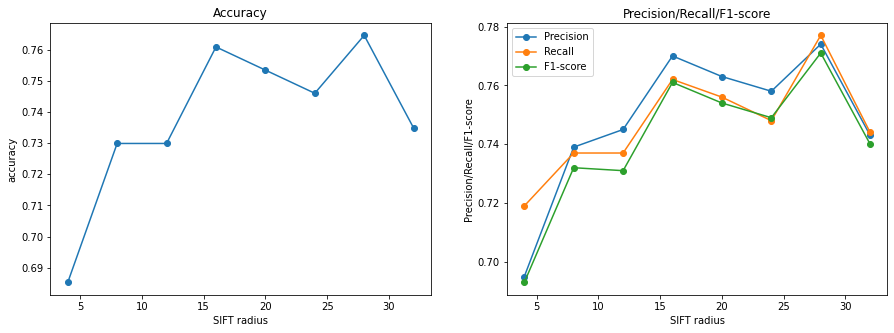

In [84]:
import pandas as pd
csv_path = "EXP_2_results.csv"
df = pd.read_csv(csv_path)

accuracy = []
precision = []
recall = []
f1 = []
x = []
for index, row in df.iterrows():
    #SIFT_radius, step_size, Accuracy, Precission, Recall, f1-score
   if(row[1] == 0):
       x.append(row[0])
       accuracy.append(row[2])
       precision.append(row[3])
       recall.append(row[4])
       f1.append(row[5])
       
plot_classification_results(x, accuracy, precision, recall, f1, "SIFT radius")

In the following table we summarize the results of the different levels of spatial pyramid. We use k = 800 visual words and DENSE SIFT descriptors with varying radius space between local features.The metrics are reported using macro average.

| SIFT radius | Step size | Accuracy | Precision| Recall| F1-score|
| --- | --- | --- | --- | --- | --- 
| 4 | 0 | 68.52% | 69.50% | 71.90% | 69.30% | 
| 4 | 4 | 65.92% | 67.00% | 69.10% | 66.10% |
| 8 | 0 | 72.98% | 73.90% | 73.70% | 73.20% | 
| 8 | 8 | 68.52% | 70.00% | 69.60% | 68.40% |
| 12 | 0 | 72.98% | 74.50% | 73.70% | 73.10% |
| 12 | 12 | 71.49% | 73.10% | 72.60% | 71.40% |
|16| 0| 76.08%|  77.00%| 76.20%|76.10%|
|16| 16| 70.87%|  72.30%| 71.20%|70.50%|
|20| 0| 75.34%|  76.30%| 75.60%|75.40%|
|20| 20| 71.37%|  72.50%| 72.30%|71.40%|
|24| 0| 74.59%|  75.80%| 74.80%|74.90%|
|24| 24| 73.97%|  74.80%| 74.60%|74.20%|
|28| 0| 76.45%|  77.40%| 77.70%|77.10%|
|28| 28| 72.24%|  73.40%| 72.90%|72.90%|
|32| 0| 73.48%|  74.30%| 74.40%|74.00%|
|32| 32| 72.49%|  7310%| 74.70%|72.90%|

Let us look at some examples with the best configuration, radius of 28 and no space between features.

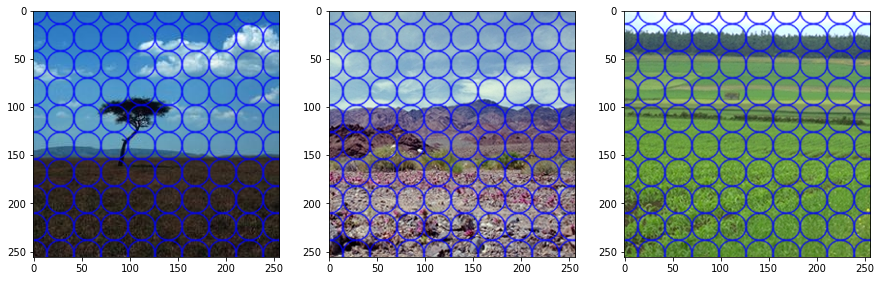

In [90]:
SIFT_detector = cv2.SIFT_create()           # Descriptors initialization
step_size = 28
multiplicator = 1

im1 = cv2.imread(train_images_filenames[1])
im2 = cv2.imread(train_images_filenames[10])
im3 = cv2.imread(train_images_filenames[20])

gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
RGB_ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)


kpDENSE = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size*multiplicator) for x in range(0, gray.shape[1], step_size*multiplicator)]

imgDENSE1 = cv2.drawKeypoints(im1, kpDENSE,  0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgDENSE2 = cv2.drawKeypoints(im2, kpDENSE,  0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
imgDENSE3 = cv2.drawKeypoints(im3, kpDENSE,  0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.rcParams['figure.figsize'] = [15, 15]

plt.subplot(131)
plt.imshow(cv2.cvtColor(imgDENSE1, cv2.COLOR_BGR2RGB))


plt.subplot(132)
plt.imshow(cv2.cvtColor(imgDENSE2, cv2.COLOR_BGR2RGB))

plt.subplot(133)
plt.imshow(cv2.cvtColor(imgDENSE3, cv2.COLOR_BGR2RGB))


plt.show()




#### Conclusions

- We observe that the best parameters are SIFT radius of 28, with an accuracy of 76.45% and no space between local features.
- By observing at the some examples using the best configuration of Dense SIFT, we infer that, in order to obtain better results, the region for each descriptor must include enough information from singular objects in the image. 

###  2.2. Experiment 2: Study the effect of the normalization of the descriptors <a class="anchor" id="exp2"></a>

In this experiment we explore the different types of normalization for the features. This step is important in order to build a cost function that is easy to optimize. Normalized features will be in a similar scale e.g. from 0 to 1, from -1 to 1. This way, all parameter updates will have the same effect when training. In this experiment we use Dense SIFT features and K Nearest Neighbor classifier.. We test the performance of L1 and L2 normalization, Max normalization and Standarization.

In [99]:

with open('input_experiment2.pickle', 'rb') as f:
    DENSESIFT_visual_words, DENSESIFTvisual_words_test = pickle.load(f)

scaler = StandardScaler()

DENSESIFT_visual_words_l1  = normalize(DENSESIFT_visual_words, norm='l1')
DENSESIFT_visual_words_l2  = normalize(DENSESIFT_visual_words, norm='l2')
DENSESIFT_visual_words_max = normalize(DENSESIFT_visual_words, norm='max')
scaler.fit(DENSESIFT_visual_words) 
DENSESIFT_visual_words_standarization = scaler.transform(DENSESIFT_visual_words)

DENSESIFTvisual_words_test_l1  = normalize(DENSESIFTvisual_words_test, norm='l1')
DENSESIFTvisual_words_test_l2  = normalize(DENSESIFTvisual_words_test, norm='l2')
DENSESIFTvisual_words_test_max = normalize(DENSESIFTvisual_words_test, norm='max')
scaler.fit(DENSESIFTvisual_words_test)
DENSESIFT_visual_words_test_standarization = scaler.transform(DENSESIFTvisual_words_test)

DENSESIFT_knn.fit(DENSESIFT_visual_words, train_labels) 

DENSESIFT_knn_l1 = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
DENSESIFT_knn_l1.fit(DENSESIFT_visual_words_l1, train_labels) 

DENSESIFT_knn_l2 = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
DENSESIFT_knn_l2.fit(DENSESIFT_visual_words_l2, train_labels) 

DENSESIFT_knn_max = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
DENSESIFT_knn_max.fit(DENSESIFT_visual_words_max, train_labels) 

DENSESIFT_knn_standarization = KNeighborsClassifier(n_neighbors=5,n_jobs=-1,metric='euclidean')
DENSESIFT_knn_standarization.fit(DENSESIFT_visual_words_standarization, train_labels) 

accuracy_dense_sift     = 100*DENSESIFT_knn.score(DENSESIFTvisual_words_test, test_labels)
accuracy_dense_sift_l1  = 100*DENSESIFT_knn_l1.score(DENSESIFTvisual_words_test_l1, test_labels)
accuracy_dense_sift_l2  = 100*DENSESIFT_knn_l2.score(DENSESIFTvisual_words_test_l2, test_labels)
accuracy_dense_sift_max = 100*DENSESIFT_knn_max.score(DENSESIFTvisual_words_test_max, test_labels)
accuracy_dense_sift_standarization = 100*DENSESIFT_knn_standarization.score(DENSESIFT_visual_words_test_standarization, test_labels)


Now we compute and plot some results for accuracy, precision and recall and f1-score

Results: Accuracy, Precision, Recall, F1-Score
Results for original: 72.99% 73.94% 73.75% 73.25%
Results for L1: 72.99% 73.94% 73.75% 73.25%
Results for L2: 72.49% 72.55% 74.57% 72.58%
Results for Max: 65.43% 65.55% 68.29% 65.55%
Results for Standarization: 80.30% 80.60% 81.38% 80.57%


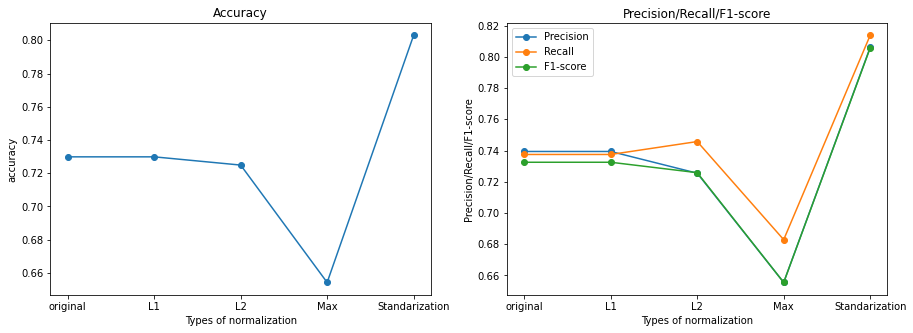

In [112]:
predictions = DENSESIFT_knn.predict(DENSESIFTvisual_words_test)
predictions_l1 = DENSESIFT_knn_l1.predict(DENSESIFTvisual_words_test_l1)
predictions_l2 = DENSESIFT_knn_l2.predict(DENSESIFTvisual_words_test_l2)
predictions_max = DENSESIFT_knn_max.predict(DENSESIFTvisual_words_test_max)
predictions_standarization = DENSESIFT_knn_standarization.predict(DENSESIFT_visual_words_test_standarization)

pred_dict = {"original":predictions, "L1": predictions_l1, "L2": predictions_l2, "Max": predictions_max, "Standarization":predictions_standarization}

accuracy = []
precision = []
recall = []
f1 = []
x = []
print("Results: Accuracy, Precision, Recall, F1-Score")
for key in pred_dict:
    x.append(key)
    acc = accuracy_score(pred_dict[key], test_labels)
    prec = precision_score(pred_dict[key], test_labels, average="macro")
    rc = recall_score(pred_dict[key], test_labels, average="macro")
    f1_s = f1_score(pred_dict[key], test_labels, average="macro")

    accuracy.append(acc)
    precision.append(prec)
    recall.append(rc)
    f1.append(f1_s)

    print("Results for {}: {:.2f}% {:.2f}% {:.2f}% {:.2f}%".format(key, 100*acc, 100*prec, 100*rc, 100*f1_s))

plot_classification_results(x, accuracy, precision, recall, f1, "Types of normalization")

In the following table we summarize the results.

| Normalization type | Accuracy | Precision | Recall | F1-Score |
| --- | --- | --- | --- | --- | 
| No normalization | 72.98% | 73.94% | 73.75% | 73.25% |
| L1 | 72.98% | 73.94% | 73.75% | 73.25% |
| L2 | 72.49% | 72.55% | 74.57% | 72.58% |
| max | 65.42% | 65.55% | 68.29% | 65.55% | 
|Standarization| 80.30% | 80.60% | 81.38% | 80.57% |


#### Conclusions

- It is clear how standarization outperforms all other strategies. This is because standarization scales the features by substracting each sample the mean and diviving by the standard deviation of the whole set. That removes the possible bad impact of outliers: In order to bring all points to a bounded range, normalization makes the points in the region of interest get squized, as outliers at high distances. Standarization uses satistical measures of the whole dataset, so it robust against outliers.

###  2.3. Experiment 3: Using SVM instead of KNN. Experiment with different kernels. <a class="anchor" id="exp3"></a>
We fit the model using Suport Vector Machine SVM strategy, with a initial training stage based on Grid Search and Cross Validation using GridSearchCV and SVC estimator from sklearn library. This methodology first performs cross-validation through the training set with the grid search algorithm over many hyperparameter values. When the best hyperparameters are obtained, the method performs a fit over the whole training set.

First of all, let us standarize the features so that they have mean zero and standard deviation equal to 1.

In [15]:
from sklearn.preprocessing import StandardScaler

with open('input_experiment2.pickle', 'rb') as f:
    DENSESIFT_visual_words, DENSESIFTvisual_words_test = pickle.load(f)

scaler = StandardScaler()
scaler.fit(DENSESIFT_visual_words) 
DENSESIFT_visual_words = scaler.transform(DENSESIFT_visual_words)
scaler.fit(DENSESIFTvisual_words_test)
DENSESIFTvisual_words_test = scaler.transform(DENSESIFTvisual_words_test)

We will define our own histogram intersection kernel, for testing its performance in the SVM classifier.In order to use the histogram intersection kernel, a custom function has to be created since it is not defined in the ScikitLearn library.


In [16]:
def intersection_kernel(A,B):
    """
    Histogram intersection kernel function defined as:
    K_int(A, B) = SUM_i(min(a_i, b_i))

    Parameters
    ---------
    A: histogram
    B: histogram

    Return
    ---------
    k_int: kernel function
    """

    # Create the kernel parameter
    k_int = np.zeros((A.shape[0], B.shape[0]))

    # Shape of the histograms
    size = A.shape[1]

    # Iterate through bins
    for idx in range(size):
        bin_A = A[:, idx].reshape(-1,1)
        bin_B = B[:, idx].reshape(-1,1)
        k_int += np.minimum(bin_A, bin_B.T)

    return k_int

Then we implement the SVM classifier using sklearn library, with the use of grid search and cross validation to find the best set of hyperparameters (kernek, regularization, gamma)

In [17]:
param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01], 'C': [0.1, 1, 10]},
              {'kernel': ['linear'], 'C': [0.1, 1, 10]},
              {'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [1, 0.1, 0.01], 'C': [0.1, 1, 10]},
              {'kernel': [intersection_kernel]}]

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

grid.fit(DENSESIFT_visual_words, train_labels)

print("BEST PARAMS", grid.best_params_, grid.best_estimator_)

grid_predictions = grid.predict(DENSESIFTvisual_words_test)

print(classification_report(test_labels, grid_predictions))

BEST PARAMS {'kernel': <function intersection_kernel at 0x000001E3B5DE8B70>} SVC(kernel=<function intersection_kernel at 0x000001E3B5DE8B70>)
              precision    recall  f1-score   support

 Opencountry       0.78      0.78      0.78       118
       coast       0.86      0.85      0.86       116
      forest       0.91      0.99      0.95       101
     highway       0.93      0.87      0.90        76
 inside_city       0.93      0.90      0.92        94
    mountain       0.89      0.86      0.88       114
      street       0.87      0.90      0.88        80
tallbuilding       0.94      0.94      0.94       108

    accuracy                           0.88       807
   macro avg       0.89      0.89      0.89       807
weighted avg       0.88      0.88      0.88       807



Let us plot a ROC curve and the precision vs recall curve of the best working SVM model.

SVM_grid


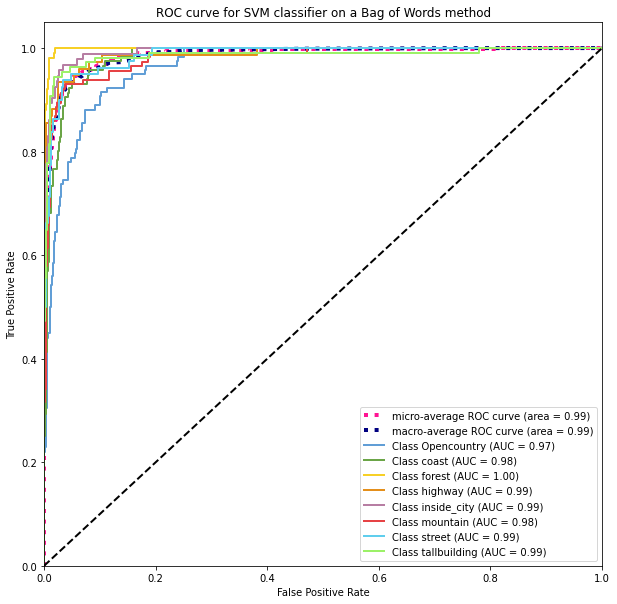

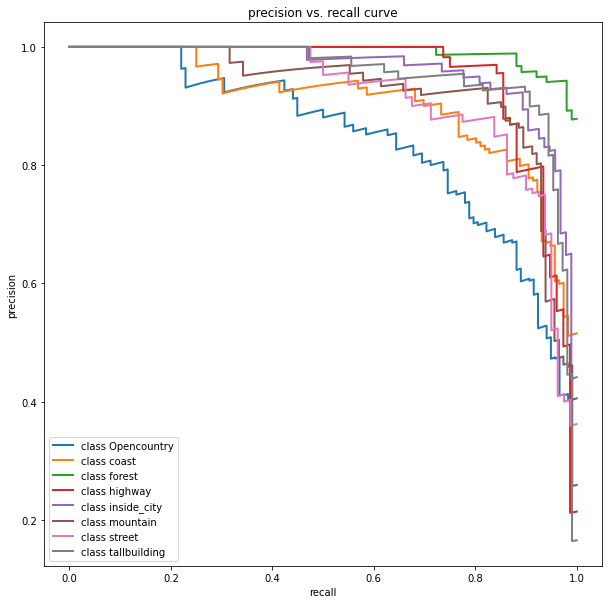

In [20]:
plot_roc_curve(DENSESIFT_visual_words, DENSESIFTvisual_words_test, train_labels, test_labels, grid, "SVM_grid")

Finally, we plot the confusion matrix of this classifier.

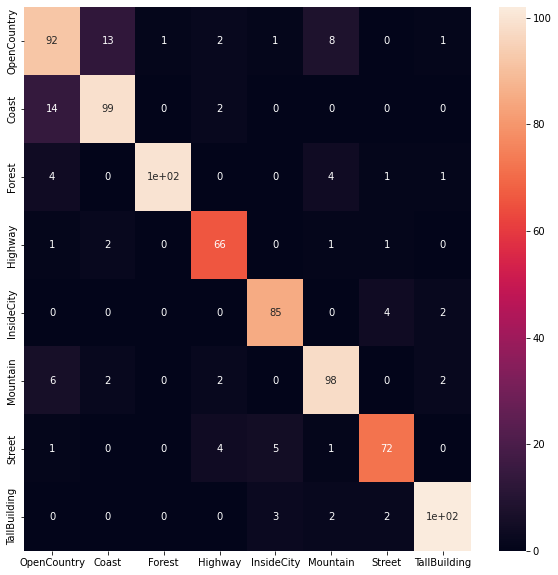

In [18]:
plot_confusion_matrix(grid_predictions, test_labels)

#### Conclusions

- From the classification report we obtain the SVM outperforms the KNN classifier, going from 80% accuracy to 88%.
- Using Grid Search and Cross Validation with many parameters of the SVM we conclude that the best performing configuration is using Histogram intersection Kernels.
- By looking at the ROC curve and the PR curve, we remark that Open Country is the most penalized class and Forest is the best performing class.
- With datasets that are unbalanced, precission vs recall curves can show us the impact in less represented classes.
- An AUC above 0.9 is an indicator of a good model, so we consider it acceptable.

###  2.4. Experiment 4: Spatial pyramids. <a class="anchor" id="exp4"></a>

We need to start from the codebook computed using the keypoint descriptors from the whole image| because the visual words remain the same. However the features used for training are generated according to the spatial pyramid scheme.

In [33]:
ima = cv2.imread(train_images_filenames[0])
gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
SIFT_detector = cv2.SIFT_create()           # Descriptors initialization
k = 800
DENSESIFT_train_descriptors = []            # All the descriptors stacked together
DENSESIFT_Train_label_per_descriptor = []   # Labels of the stacked descriptors (1 label per descriptor)
step_size = 28

Load of compute the descriptors and the codebook

In [34]:
filename = "DENSESIFT_visual_words_train_k_{}_step_{}".format(k, step_size)
if os.path.isfile('./' + filename + '.pickle'):
    with open(filename + '.pickle', 'rb') as f:
        DENSESIFT_features = pickle.load(f)
else:
    # Keypoints for the DENSE SIFT
    DENSEkpt = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) for x in range(0, gray.shape[1], step_size)]

    # Obtain the descriptors of all the train images 
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

        # DENSE SIFT
        _, des = SIFT_detector.compute(gray, DENSEkpt)
        DENSESIFT_train_descriptors.append(des)
        DENSESIFT_Train_label_per_descriptor.append(labels)

    DENSESIFT_features=np.vstack(DENSESIFT_train_descriptors)
    with open(filename + '.pickle', 'wb') as f:
        pickle.dump(DENSESIFT_features, f)

filename = "DENSESIFT_CODEBOOK_k_{}_step_{}".format(k, step_size)
if os.path.isfile('./' + filename + '.pickle'):
    with open(filename + '.pickle', 'rb') as f:
        DENSESIFT_codebook = pickle.load(f)
else:
    # -- K-MEANS --
    DENSESIFT_codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
    DENSESIFT_codebook.fit(DENSESIFT_features)

    with open(filename + '.pickle', 'wb') as f:
        pickle.dump(DENSESIFT_codebook, f)


We define functions to perform the spatial pyramid algorithm:
- spatial_pyramids: Given an image and a pyramid level, it manages the operations for spatial pyramid calculations, and returns the final descriptor of visual words.
- block_descriptors: It recieves an image and a mask. It devides the region of the mask in 4 blocks and computes visual words features separately. It returns the concatenated descriptors of visual words and masks of the four blocks.
- compute_Bow_descriptor: It recieves the image and a mask with the region to compute visual words, and returns the descriptor. It is the lowest level. 

In [35]:
SIFT_detector = cv2.SIFT_create()           # Descriptors initialization

def spatial_pyramids(image, level, plot):
    # Compute the histogram of the original whole image and store it in a variable in which all the
    # histograms will be concatenated
    descriptors = np.concatenate(compute_Bow_descriptor(image, 0, image.shape[0], 0, image.shape[1], plot, pos = 1)[:,np.newaxis])
    # Compute the 2nd level histograms (4 blocks) and concatenate them to the histogram variable
    if level >= 1:
        block_descriptor, masks = block_descriptors(image, mask = None, plot=plot)
        descriptors = np.concatenate((descriptors, block_descriptor))

    # Compute the 3rd level histograms (16 blocks) and concatenate them to the histogram variable
    if level == 2:
        for i in range(len(masks)):
            block_descriptor, _ = block_descriptors(image, mask = masks[i], plot=plot)
            descriptors = np.concatenate((descriptors, block_descriptor))
            

    return descriptors
    
def block_descriptors(image, mask=None, plot=False):
    if mask is not None:
        w = mask[1] - mask[0]
        h = mask[3] - mask[2]
        offset_x = mask[0]
        offset_y = mask[2]
        cX = int(offset_x + (w / 2))
        cY = int(offset_y + (h / 2))
        

    # If the image is from the BBDD set (in other words, the image is cropped right in the frame),
    # find the center of the image
    else:
        # h: height, w: width, c: channels(not used)
        h, w, c = image.shape
        cX = int(w / 2)
        cY = int(h / 2)
        offset_x = 0
        offset_y = 0
        
    # List in which all the masks are stored
    pos = 0
    des = [] # Here we store the concatenated histograms of visual words
    masks = []
    # From the centroid (either from the BBDD image or from the mask) divide the image in 4 different masks
    des = np.array([])

    if plot == True:
        plt.figure()

    for i in range(2):
        for j in range(2):
          
            # Coordinates contained in the current block
            x_from = int(cX - w/2 if i == 0 else cX)
            x_to = int(cX if i == 0 else cX + w/2)
            y_from = int(cY - h/2 if j == 0 else cY)
            y_to = int(cY if j == 0 else cY + h/2)

            mask_i = [x_from, x_to, y_from, y_to]
            masks.append(mask_i)
            block_descriptor = compute_Bow_descriptor(image, x_from, x_to, y_from, y_to, plot, pos)
            des = np.append(des, block_descriptor)
            pos = pos + 1
    if plot == True:
        plt.show()
            
    return des, masks


def compute_Bow_descriptor(img, x_from, x_to, y_from, y_to, plot=False, pos = 1):  
    step_size = 12
    DENSEkpt = [cv2.KeyPoint(x, y, step_size) for y in range(y_from, y_to, step_size) for x in range(x_from, x_to, step_size)]

    imgDENSE = cv2.drawKeypoints(img, DENSEkpt,  0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    if plot == True:
        # Plot the image with the number of keypoints
        plt.rcParams['figure.figsize'] = [10, 10]
        plt.subplot(1, 4, pos+1)
        plt.imshow(imgDENSE)

    _, res = SIFT_detector.compute(img, DENSEkpt)
    words=DENSESIFT_codebook.predict(res)
    block_descriptor=np.bincount(words,minlength=k)  

    return block_descriptor


Let us do some testing of the spatial pyramid operation with an example image. For level 2 spatial pyramid, we concatenate 800 features for the whole image, 4 blocks of 800 features, and finally 16 blocks of 800 features, which results in a feature array of 16800 features.

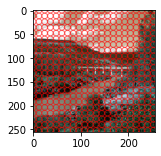

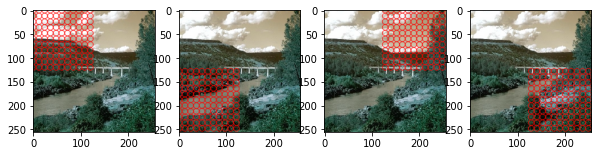

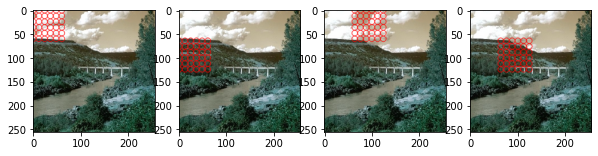

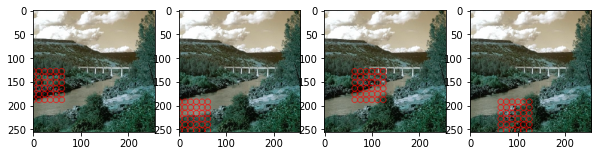

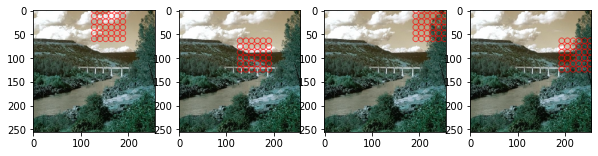

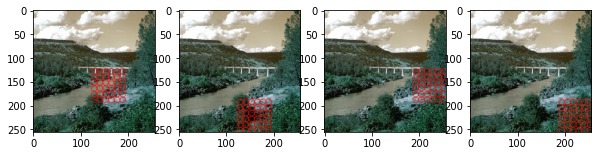

Pyramid concatenation with 800 words has shape:16800


In [36]:
ima = cv2.imread(train_images_filenames[0])
gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
pyramid_level = 2
res = spatial_pyramids(ima, level = pyramid_level, plot=True)
size_descriptor = res.shape[0]
print("Pyramid concatenation with {} words has shape:{}".format(k, size_descriptor))

Now we perform the feature extraction of the train and test sets, and store the resulting features.

In [37]:
f_name = "DENSESIFT_pyramid_visual_words_level_{}_k_{}_step_{}".format(pyramid_level, k, step_size)
if os.path.isfile('./' + f_name + '.pickle'):
    with open(f_name + '.pickle', 'rb') as f:
        DENSESIFT_pyramid_visual_words = pickle.load(f)

else:
    # Compute the histogram of the visual words
    DENSESIFT_pyramid_visual_words=np.zeros((len(train_images_filenames),size_descriptor),dtype=np.float32)
    for i in range(len(train_images_filenames)):    
        filename=train_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        res = spatial_pyramids(ima, level = pyramid_level, plot=False)
        DENSESIFT_pyramid_visual_words[i,:] = res
    with open(f_name + '.pickle', 'wb') as f:
        pickle.dump(DENSESIFT_pyramid_visual_words, f)


In [38]:
f_name = "DENSESIFT_pyramid_visual_words_test_level_{}_k_{}_step_{}".format(pyramid_level, k, step_size)

if os.path.isfile('./' + f_name + '.pickle'):
    with open(f_name + '.pickle', 'rb') as f:
        DENSESIFT_pyramid_visual_words_test = pickle.load(f)
else:

    # -- FEATURE EXTRACTION (TEST SET) --
    DENSESIFT_pyramid_visual_words_test=np.zeros((len(test_images_filenames),size_descriptor),dtype=np.float32)

    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        res = spatial_pyramids(ima, level = pyramid_level, plot=False)
        DENSESIFT_pyramid_visual_words_test[i,:]=res

    with open(f_name + '.pickle', 'wb') as f:
        pickle.dump(DENSESIFT_pyramid_visual_words_test, f)

Finally we train an SVM classifier using this features.

In [42]:
# STANDARIZE train and test
scaler = StandardScaler()

scaler.fit(DENSESIFT_pyramid_visual_words) 
DENSESIFT_pyramid_visual_words = scaler.transform(DENSESIFT_pyramid_visual_words)

scaler.fit(DENSESIFT_pyramid_visual_words_test)
DENSESIFT_pyramid_visual_words_test = scaler.transform(DENSESIFT_pyramid_visual_words_test)
classifier = SVC(C=0.1, kernel= "linear")

classifier.fit(DENSESIFT_pyramid_visual_words, train_labels)

predictions = classifier.predict(DENSESIFT_pyramid_visual_words_test)

print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

 Opencountry       0.69      0.79      0.74       118
       coast       0.84      0.76      0.80       116
      forest       0.86      0.95      0.90       101
     highway       0.97      0.89      0.93        76
 inside_city       0.90      0.88      0.89        94
    mountain       0.86      0.83      0.85       114
      street       0.94      0.90      0.92        80
tallbuilding       0.89      0.88      0.88       108

    accuracy                           0.86       807
   macro avg       0.87      0.86      0.86       807
weighted avg       0.86      0.86      0.86       807



Let us plot a ROC curve

roc_curve_level_2_k_800_step_28


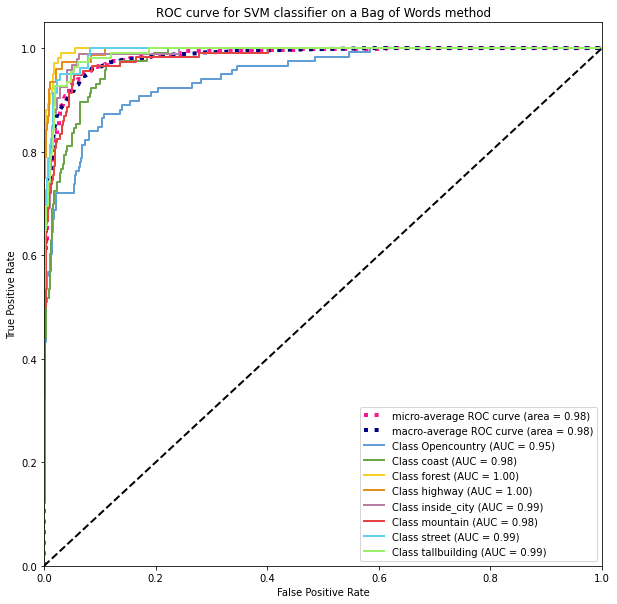

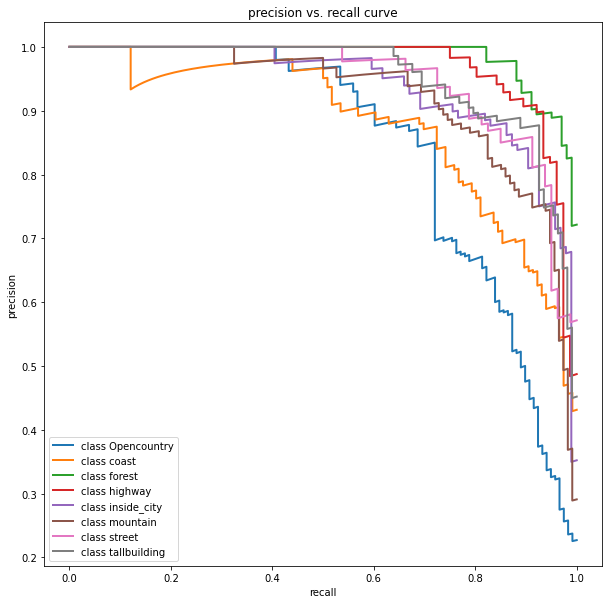

In [43]:
f_name = 'roc_curve_level_{}_k_{}_step_{}'.format(pyramid_level, k, step_size)
plot_roc_curve(DENSESIFT_pyramid_visual_words, DENSESIFT_pyramid_visual_words_test, train_labels, test_labels, classifier, f_name)

Now we plot the confusion matrix

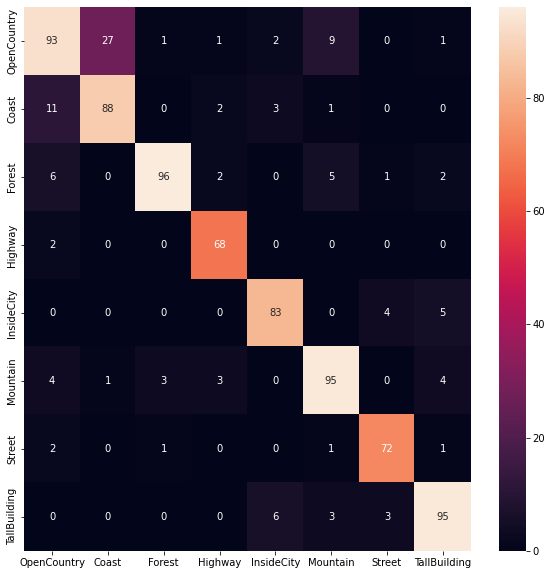

In [44]:
plot_confusion_matrix(predictions, test_labels)

In the following table we summarize the results of the different levels of spatial pyramid. We use k = 800 visual words and DENSE SIFT descriptors with radius = 12 and no space between local features.
The metrics are reported using macro average.

| Pyramid Level | Accuracy | Precision | Recall | F1-Score |
| -- | --- | --- | --- | --- |
| 0 | 86% | 85% | 86% | 86% | 86% | 
| 1 | 89% | 89% | 89% | 89% | 89% | 
| 2 | 88% | 89% | 89% | 89% | 89% | 

#### Conclusions

- We observe that there is a slight increase in performance whe adding a level of spatial pyramid, prom 86% to 89%. However, there is a slight decrease in accuracy when adding a second level. We will use 1 level for our final classifier.


- Looking at the classification_record result, we observe that the class Opencountry has the most amount of samples in the test set (14.60%), hence it decreases the precision. In contrast, Highway class has shows the best accuracy because it has less samples (9.41%) i.e. he dataset is unbalanced. This can be addressed by applying weight classes in the training.

###  2.5. Experiment 6: Fisher vectors <a class="anchor" id="exp5"></a>
The Fisher Vector representation of images can be seen as an extension of the Bag of Visual Words. This vectors are the concatenation of the gradients of the loglikelihood with respect of the model parameters to represent the image. As the probabilities of the descriptors are needed, instead of using the Kmeans algorithm, the Gaussian Mixture Model is used.

The process is the following: Image -> Descriptors -> GMM -> Fisher Vectors -> SVM

Credits to:

[1] [Machine Intelligence Lecture from the University of Waterloo](https://www.youtube.com/watch?v=c08dfv0iFJo&feature=youtu.be)

[2] [jonasrothfuss GitHub repository](https://github.com/jonasrothfuss/fishervector)

[3] [danoneata GitHub repository](https://gist.github.com/danoneata/9927923/)

To compute the Fisher Vectors DENSE SIFT with keypoints of size 12 and without space between them will be used as it is the method with better results.

In [3]:
import pickle

# --- OBTAIN TRAIN DESCRIPTORS ---
if os.path.isfile('./dense.pickle'):
    with open('dense.pickle', 'rb') as f:
        DENSESIFT_train_descriptors, DENSESIFT_features = pickle.load(f)
    print('DENSE SIFT features loaded from storage')

else:
    DENSESIFT_train_descriptors = []
    DENSESIFT_Train_label_per_descriptor = []
    
    SIFT_detector = cv2.SIFT_create()           # Descriptors initialization
    step_size = 12
    gray = cv2.imread(train_images_filenames[0])
    kpDENSE = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) for x in range(0, gray.shape[1], step_size)]

    # Obtain the descriptors of all the train images 
    for filename,labels in zip(train_images_filenames,train_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

        # DENSE SIFT
        _, des = SIFT_detector.compute(gray, kpDENSE)
        DENSESIFT_train_descriptors.append(des)
        DENSESIFT_Train_label_per_descriptor.append(labels)

    DENSESIFT_features=np.vstack(DENSESIFT_train_descriptors)

    with open('dense.pickle', 'wb') as f:
        pickle.dump([DENSESIFT_train_descriptors, DENSESIFT_features], f)

# --- OBTAIN TEST DESCRIPTORS ---
if os.path.isfile('./dense_test.pickle'):
    with open('dense_test.pickle', 'rb') as f:
        DENSESIFT_test_descriptors, DENSESIFTtest_features = pickle.load(f)
    print('DENSE SIFT features loaded from storage')

else:
    DENSESIFT_test_descriptors = []
    DENSESIFT_test_label_per_descriptor = []
    
    SIFT_detector = cv2.SIFT_create()           # Descriptors initialization
    step_size = 12
    gray = cv2.imread(test_images_filenames[0])
    kpDENSE = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size) for x in range(0, gray.shape[1], step_size)]

    # Obtain the descriptors of all the train images 
    for filename,labels in zip(test_images_filenames,test_labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)

        # DENSE SIFT
        _, des = SIFT_detector.compute(gray, kpDENSE)
        DENSESIFT_test_descriptors.append(des)
        DENSESIFT_test_label_per_descriptor.append(labels)

    DENSESIFTtest_features=np.vstack(DENSESIFT_test_descriptors)

    with open('dense_test.pickle', 'wb') as f:
        pickle.dump([DENSESIFT_test_descriptors, DENSESIFTtest_features], f)

DENSE SIFT features loaded from storage
DENSE SIFT features loaded from storage


Function to extract the Fisher Vectors from a GMM and the input data

In [4]:
def fisher_vector(xx, gmm):
    """Computes the Fisher vector on a set of descriptors.
    Parameters
    ----------
    xx: array_like, shape (N, D) or (D, )
        The set of descriptors
    gmm: instance of sklearn mixture.GMM object
        Gauassian mixture model of the descriptors.
    Returns
    -------
    fv: array_like, shape (K + 2 * D * K, )
        Fisher vector (derivatives with respect to the mixing weights, means
        and variances) of the given descriptors.
    """
    xx = np.atleast_2d(xx)
    N = xx.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(xx)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_xx = np.dot(Q.T, xx) / N
    Q_xx_2 = np.dot(Q.T, xx ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_xx - Q_sum * gmm.means_
    d_sigma = (
        - Q_xx_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_xx * gmm.means_)

    # Merge derivatives into a vector.
    return np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten()))

Obtain the Fisher Vectors from both training and test descriptors.

In [5]:
from sklearn.mixture import GaussianMixture as GMM
import random
from tqdm.notebook import tqdm
num_gmm = 16

# Fit the GMM
indices = random.sample(range(0,DENSESIFT_features.shape[0]),num_gmm*1500)
sample = DENSESIFT_features[indices,:]

print('Fitting the GMM')
gmm = GMM(n_components=num_gmm,covariance_type='diag')
gmm.fit(sample)
print('GMM fitted')

# Obtain the Fisher Vectors for the training dataset
train_descriptors_FV = []
for train_descriptor in tqdm(DENSESIFT_train_descriptors, desc='Train Fisher Vectors'):
    start = 0
    length = train_descriptor.shape[0]
    stop = start + length
    train_descriptor = train_descriptor[:,:DENSESIFT_train_descriptors[0].shape[1]]
    start = stop
    train_descriptor_fisher = fisher_vector(train_descriptor, gmm)
    train_descriptors_FV.append(train_descriptor_fisher)
    image_fv = np.vstack(train_descriptors_FV)
    image_fv = np.sign(image_fv) * np.abs(image_fv) ** 0.5
    norms = np.sqrt(np.sum(image_fv ** 2, 1))
    train_FV = image_fv / norms.reshape(-1,1)

# Obtain the Fisher Vectors for the training dataset
test_descriptors_FV = []
for test_descriptor in tqdm(DENSESIFT_test_descriptors, desc='Test Fisher Vectors'):
    start = 0
    length = test_descriptor.shape[0]
    stop = start + length
    test_descriptor = test_descriptor[:,:DENSESIFT_test_descriptors[0].shape[1]]
    start = stop
    test_descriptor_fisher = fisher_vector(test_descriptor, gmm)
    test_descriptors_FV.append(test_descriptor_fisher)
    image_fv = np.vstack(test_descriptors_FV)
    image_fv = np.sign(image_fv) * np.abs(image_fv) ** 0.5
    norms = np.sqrt(np.sum(image_fv ** 2, 1))
    test_FV = image_fv / norms.reshape(-1,1)

Fitting the GMM
GMM fitted


Train Fisher Vectors:   0%|          | 0/1881 [00:00<?, ?it/s]

Test Fisher Vectors:   0%|          | 0/807 [00:00<?, ?it/s]

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Parameters tested
param_grid = [{'kernel': ['rbf'], 'gamma': [1, 0.1, 0.01], 'C': [0.1, 1, 10]},
              {'kernel': ['linear'], 'C': [0.1, 1, 10]},
              {'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [1, 0.1, 0.01], 'C': [0.1, 1, 10]},
              {'kernel': [intersection_kernel]}]
# Best Parameters
param_grid = [{'kernel': ['rbf'], 'gamma': [1], 'C': [10]}]


grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')

grid.fit(train_FV, train_labels)

print("BEST PARAMS", grid.best_params_, grid.best_estimator_)

grid_predictions = grid.predict(test_FV)

print("classification_report\n", classification_report(test_labels, grid_predictions))

BEST PARAMS {'C': 10, 'gamma': 1, 'kernel': 'rbf'} SVC(C=10, gamma=1)
classification_report
               precision    recall  f1-score   support

 Opencountry       0.76      0.80      0.78       118
       coast       0.80      0.82      0.81       116
      forest       0.91      0.92      0.92       101
     highway       0.93      0.82      0.87        76
 inside_city       0.84      0.85      0.85        94
    mountain       0.88      0.86      0.87       114
      street       0.88      0.89      0.88        80
tallbuilding       0.87      0.87      0.87       108

    accuracy                           0.85       807
   macro avg       0.86      0.85      0.85       807
weighted avg       0.85      0.85      0.85       807



Let's plot some results for the ROC curve and the PR curve.

Fisher_vectors_grid


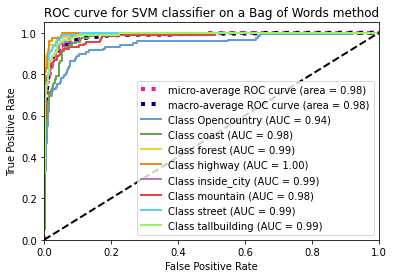

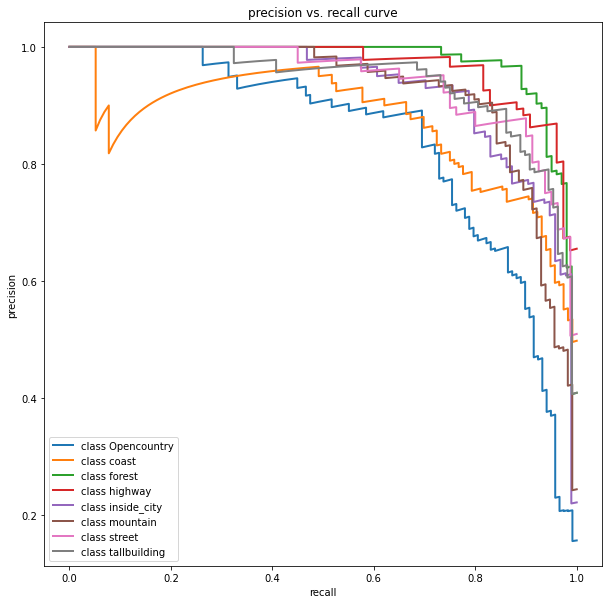

In [11]:
plot_roc_curve(train_FV, test_FV, train_labels, test_labels, grid, "Fisher_vectors_grid")

Finally, we take a look at the confusion matrix

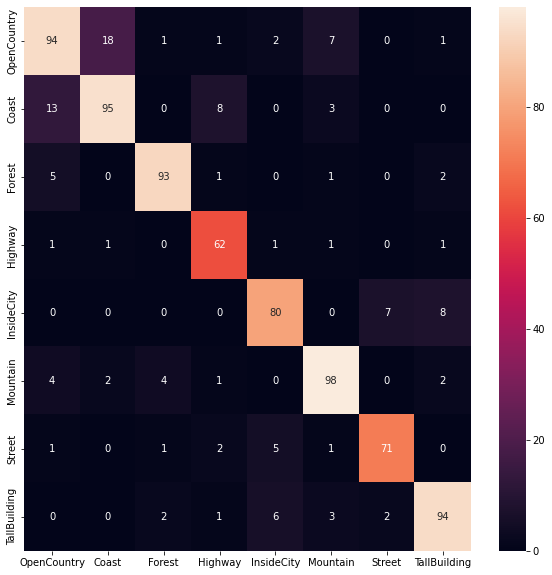

In [13]:
plot_confusion_matrix(grid_predictions, test_labels)

#### Conclusions
- The feature extraction with Fisher Vectors does not perform better than the previous methods.
- We are not able to improve the performance in the most penalized class, which is Opencountry. In the test set, we are not able to predict correctly more than 118 samples.
- An important observation is that with Ficher Features, the best params in the SVM are RBF kernel with regularization of 10 and gamma = 1.

###  2.7. Experiment 6: XGBoost Classifier <a class="anchor" id="exp7"></a>
Extreme Gradient Boosting, better known as XGBoost is a decision-tree-based ensemble ML algorithm that uses a gradient boosting framework. Decision trees build classification or regression models in the form of a tree structure to break down the data set into smaller and smaller subsets depending on a set of criteria of the features to facilitate the prediction.

When separating the data in a tree model, instead of taking all the features at once, several subsets of data chosen randomly from the training dataset can be taken. This is called Bagging (Bootstrap Aggregation) and it is used to reduce the variance of a decision tree. Each collection of data is used to train their trees ending up with an ensemble of different models which is more robust than a single decision tree. To decide the final prediction, the average of all the predictions from the different trees are used. Random Forest is a bagging-based algorithm with a key difference wherein only a subset of features at random are taken.

Boosting is another ensemble technique to create a collection of predictors. In this algorithm, learners are learned sequentially with early learners fitting simple models to the data and then analyzing data for errors. In other words, consecutive trees are fitted, and at every step, the goal is to solve the error from the prior tree. When an input is misclassified by a hypothesis, its weight is increased so that next hypothesis is more likely to classify it correctly. When instead of increasing the weight the algorithm tries to optimize a loss function is called Gradient Boosting Decision Tree (Gradient Descent and Boosting).


[1] [C. Tianqi and C. Guestrin. XGBoost: A Scalable Tree Boosting System. In Proceed-
ings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery
and Data Mining, page 785–794, 2016.](https://arxiv.org/abs/1603.02754)

[2] [An End-to-End Guide to Understand the Math behind XGBoost](https://www.analyticsvidhya.com/blog/2018/09/an-end-to-end-guide-to-understand-the-math-behind-xgboost)

The algorithm cannot work with string labels, so the first step is to encode them as integers.


In [29]:
from sklearn.preprocessing import LabelEncoder

# Change each train/test string label for a integer
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

Scale the data as in the SVM.

In [30]:
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


with open('input_experiment2.pickle', 'rb') as f:
    DENSESIFT_visual_words, DENSESIFTvisual_words_test = pickle.load(f)

scaler = StandardScaler()
scaler.fit(DENSESIFT_visual_words) 
DENSESIFT_visual_words = scaler.transform(DENSESIFT_visual_words)
scaler.fit(DENSESIFTvisual_words_test)
DENSESIFTvisual_words_test = scaler.transform(DENSESIFTvisual_words_test)

The XGBoost has a lot of parameters the most important are fine-tunned using cross-validation:

In [31]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Best parameters
param_grid = {
            'colsample_bytree': [0.4],
            'gamma': [0.1],
            'max_depth': [4],
            'subsample': [1]
            }

# Initialize the model
model = xgboost.XGBClassifier(learning_rate=0.1, 
                              n_estimators=1000,
                              reg_alpha = 0.3,
                              booster='gbtree',
                              objective='binary:logistic',
                              use_label_encoder =False,
                              eval_metric='mlogloss', )

# Grid Search to fine-tune the parameters using cross-validation with 5 folds
grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid.fit(DENSESIFT_visual_words, train_labels)

print("BEST PARAMS:\n", grid.best_params_)

grid_predictions = grid.predict(DENSESIFTvisual_words_test)

# Inverse the label transformation
grid_predictions = label_encoder.inverse_transform(grid_predictions)
test_labels = label_encoder.inverse_transform(test_labels)

print(classification_report(test_labels, grid_predictions))

BEST PARAMS:
 {'colsample_bytree': 0.4, 'gamma': 0.1, 'max_depth': 4, 'subsample': 1}
              precision    recall  f1-score   support

 Opencountry       0.75      0.79      0.77       118
       coast       0.82      0.79      0.81       116
      forest       0.91      0.98      0.94       101
     highway       0.94      0.83      0.88        76
 inside_city       0.82      0.90      0.86        94
    mountain       0.84      0.86      0.85       114
      street       0.88      0.76      0.82        80
tallbuilding       0.88      0.86      0.87       108

    accuracy                           0.85       807
   macro avg       0.86      0.85      0.85       807
weighted avg       0.85      0.85      0.85       807



Then, we plot the confusion matrix.

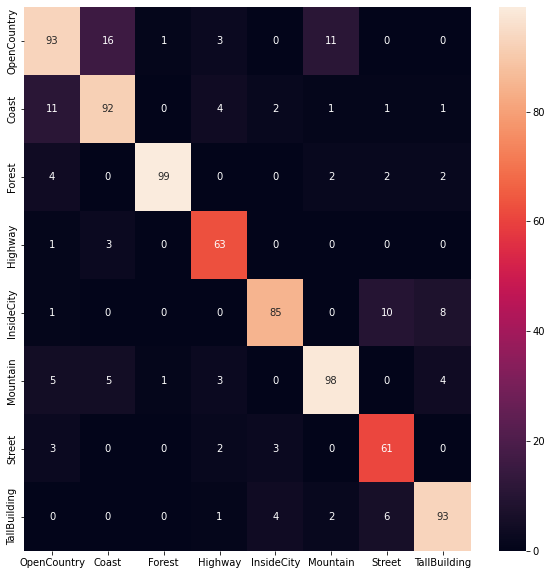

In [25]:
plot_confusion_matrix(grid_predictions, test_labels)

#### Conclusions
- This classifier does not outperform SVM, giving an accuracy of 85%.
- Looking at the confusion matrix, it can be seen that it show the same problems as the past methods, with some samples of the classes Open Country and Coast.

### 2.8 Our best method
We present the results of our best performing method with has the following caracteristics:
- Local feature extraction using Dense SIFT, with 28 radius descriptors and no stride between descriptors.
- KMeans visual words codebook using 800 different classes
- Spatial Pyramid strategy to construct histograms of visual words, of level 1
- Feature standardization
- SVM classifier, with histogram intersection kernel

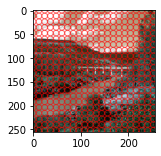

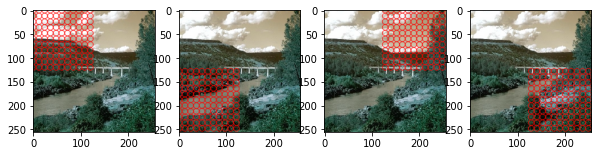

Pyramid concatenation with 800 words has shape:4000
              precision    recall  f1-score   support

 Opencountry       0.76      0.80      0.78       118
       coast       0.85      0.83      0.84       116
      forest       0.88      0.97      0.92       101
     highway       0.93      0.89      0.91        76
 inside_city       0.87      0.90      0.89        94
    mountain       0.87      0.83      0.85       114
      street       0.95      0.86      0.90        80
tallbuilding       0.90      0.88      0.89       108

    accuracy                           0.87       807
   macro avg       0.88      0.87      0.87       807
weighted avg       0.87      0.87      0.87       807

best_model


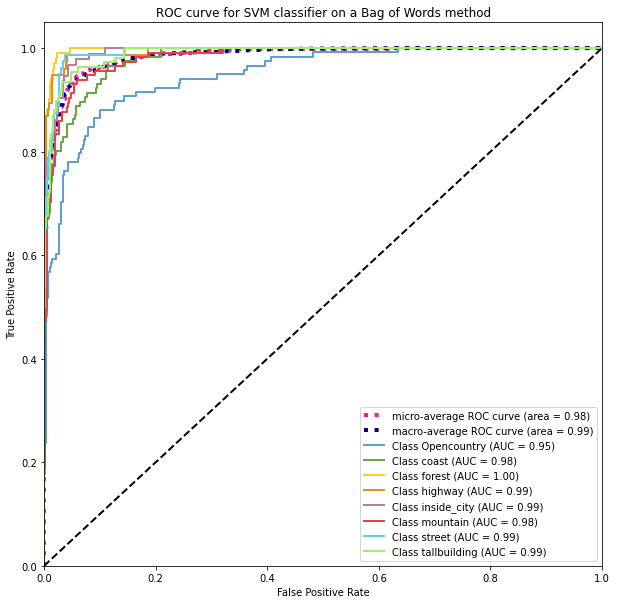

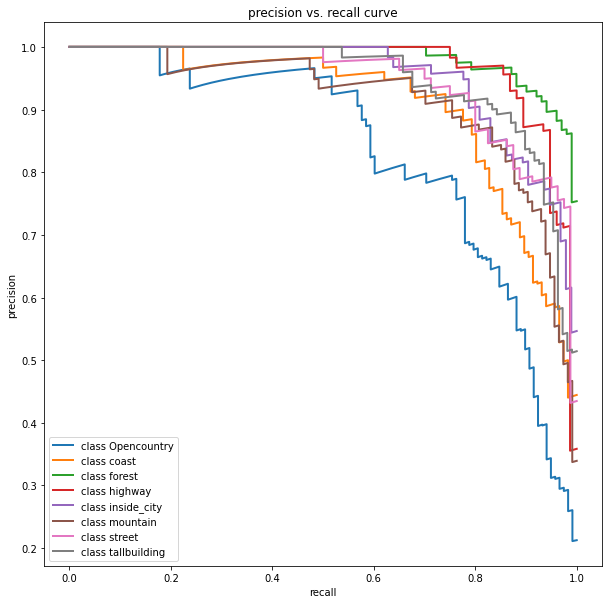

In [29]:
ima = cv2.imread(train_images_filenames[0])
gray = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
pyramid_level = 1
res = spatial_pyramids(ima, level = pyramid_level, plot=True)
size_descriptor = res.shape[0]
print("Pyramid concatenation with {} words has shape:{}".format(k, size_descriptor))

SIFT_detector = cv2.SIFT_create()           # Descriptors initialization
k = 800
step_size = 28

f_name = "DENSESIFT_pyramid_visual_words_level_{}_k_{}_step_{}".format(pyramid_level, k, step_size)
if os.path.isfile('./' + f_name + '.pickle'):
    with open(f_name + '.pickle', 'rb') as f:
        DENSESIFT_pyramid_visual_words = pickle.load(f)

else:
    # Compute the histogram of the visual words
    DENSESIFT_pyramid_visual_words=np.zeros((len(train_images_filenames),size_descriptor),dtype=np.float32)
    for i in range(len(train_images_filenames)):    
        filename=train_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        res = spatial_pyramids(ima, level = pyramid_level, plot=False)
        DENSESIFT_pyramid_visual_words[i,:] = res
    with open(f_name + '.pickle', 'wb') as f:
        pickle.dump(DENSESIFT_pyramid_visual_words, f)

f_name = "DENSESIFT_pyramid_visual_words_test_level_{}_k_{}_step_{}".format(pyramid_level, k, step_size)

if os.path.isfile('./' + f_name + '.pickle'):
    with open(f_name + '.pickle', 'rb') as f:
        DENSESIFT_pyramid_visual_words_test = pickle.load(f)
else:

    # -- FEATURE EXTRACTION (TEST SET) --
    DENSESIFT_pyramid_visual_words_test=np.zeros((len(test_images_filenames),size_descriptor),dtype=np.float32)

    for i in range(len(test_images_filenames)):
        filename=test_images_filenames[i]
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        res = spatial_pyramids(ima, level = pyramid_level, plot=False)
        DENSESIFT_pyramid_visual_words_test[i,:]=res

    with open(f_name + '.pickle', 'wb') as f:
        pickle.dump(DENSESIFT_pyramid_visual_words_test, f)

# STANDARIZE train and test
scaler = StandardScaler()

scaler.fit(DENSESIFT_pyramid_visual_words) 
DENSESIFT_pyramid_visual_words = scaler.transform(DENSESIFT_pyramid_visual_words)
scaler.fit(DENSESIFT_pyramid_visual_words_test)
DENSESIFT_pyramid_visual_words_test = scaler.transform(DENSESIFT_pyramid_visual_words_test)

classifier = SVC(C=0.1, kernel= intersection_kernel, class_weight = 'balanced')

classifier.fit(DENSESIFT_pyramid_visual_words, train_labels)

predictions = classifier.predict(DENSESIFT_pyramid_visual_words_test)

print(classification_report(test_labels, predictions))

f_name = 'best_model'
plot_roc_curve(DENSESIFT_pyramid_visual_words, DENSESIFT_pyramid_visual_words_test, train_labels, test_labels, classifier, f_name)

Now we compute the confusion matrix.

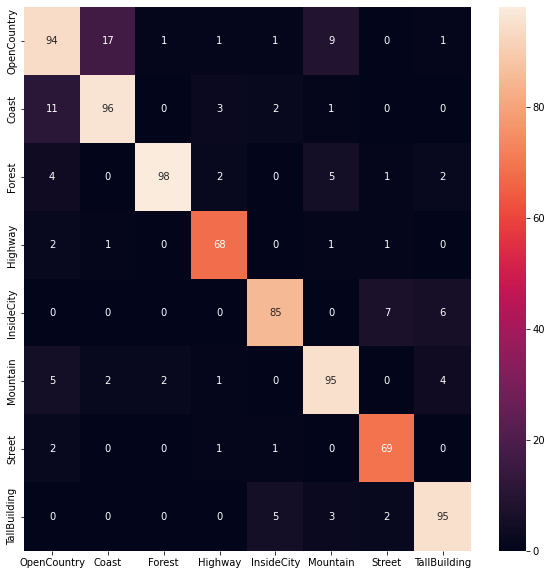

In [32]:
plot_confusion_matrix(predictions, test_labels)

#### Conclusions
- We obtain an accuracy of 89% for our best performing method, wich is an acceptable but can be further improved.
- We still have problems classifying OpenCountry classe, which is the one with most samples in the test set. This class gets confused with Coast.

## 3 Annex: Functions to plot results
Definition of helper functions to plot results

Function to plot ROC curves, credits to https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [9]:
def plot_roc_curve(train_features=None, test_features=None, train_labels=None, test_labels=None, classifier=None, f_name="roc_curve"):
    
    classes=['Opencountry', 'coast', 'forest', 'highway', 'inside_city','mountain', 'street', 'tallbuilding']
    y_train = label_binarize(train_labels, classes=classes)
    y_test = label_binarize(test_labels, classes=classes)
    n_classes = y_train.shape[1]
    print(f_name)
    if os.path.isfile('./' + "roc_curve_" + f_name + '.pickle'+ f_name + '.pickle'):
        with open(f_name + '.pickle', 'rb') as f:
            roc = pickle.load(f)
            fpr, tpr, roc_auc = roc[0], roc[1], roc[2]
    else:
        classifier = OneVsRestClassifier(classifier)
        classifier.fit(train_features, y_train)
        try:
            y_score = classifier.decision_function(test_features)
        except:
            y_score = classifier.predict_proba(test_features)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        with open("roc_curve_" + f_name + '.pickle', 'wb') as f:
            pickle.dump([fpr, tpr, roc_auc], f)

    
    plt.figure()
    plt.rcParams['figure.figsize'] = [10, 10]

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )
    lw = 2

    colors = cycle(["#619ED6", "#6BA547", "#F7D027", "#E48F1B", "#B77EA3", "#E64345", "#60CEED", "#9CF168"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="Class {0} (AUC = {1:0.2f})".format(classes[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve for SVM classifier on a Bag of Words method")
    plt.legend(loc="lower right")
    plt.show()

    if os.path.isfile('./' + "precision_recall_" + f_name + '.pickle'+ f_name + '.pickle'):
        with open("precision_recall_" + f_name + '.pickle', 'rb') as f:
            pr = pickle.load(f)
            recall = pr[0], pr[1]
    else:
        # Plot Precision recall curve
        precision = dict()
        recall = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],y_score[:, i])
        with open("precision_recall_" + f_name + '.pickle', 'wb') as f:
            pickle.dump([precision, recall], f)
    
    for i in range(n_classes):                                                        
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(classes[i]))
        
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

Function to plot Accuracy, Precision, Recall and F1 score

In [13]:
import matplotlib.pyplot as plt
def plot_classification_results(x, accuracy, precision, recall, f1, x_label):
    fig, axes = plt.subplots(1,2,figsize=(15,5))

    axes[0].set_title('Accuracy')
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel('accuracy')
    axes[0].plot(x, accuracy, marker="o")

    axes[1].set_title('Precision/Recall/F1-score')
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel('Precision/Recall/F1-score')
    axes[1].plot(x, precision, marker="o", label="Precision")
    axes[1].plot(x, recall, marker="o", label="Recall")
    axes[1].plot(x, f1, marker="o", label="F1-score")
    axes[1].legend(loc="best")

Function to compute a confusion matrix

In [12]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

def plot_confusion_matrix(predictions, labels):
    cmat = confusion_matrix(predictions, test_labels)
    labels = ['OpenCountry', 'Coast', 'Forest', 'Highway', 'InsideCity', 'Mountain', 'Street', 'TallBuilding']


    df = pd.DataFrame(cmat, index = labels, columns = labels)

    sn.heatmap(df, annot=True)

